In [1]:
import glob
import json

log_dir = "../logs/"

all_logs = []
for log_file in glob.glob(log_dir + "*.json"):
    with open(log_file, "r") as f:
        log_file = log_file.split("results_")[1].split(".")[0]
        all_logs.append([log_file, json.load(f)])

In [2]:
def add_values(acc, entry):
    """
    Add values to an entry dict.
    """
    acc["chamfer"] += entry["chamfer"]
    acc["depth_loss"] += entry ["depth_loss"]
    acc["f_score"] += entry["f_score"]
    acc["iou"] += entry["iou"]
    acc["mask_loss"] += entry["mask_loss"]
    
def average_values(acc, num):
    """
    Average values in an entry dict.
    """
    acc["chamfer"] /= num
    acc["depth_loss"] /= num
    acc["f_score"] /= num
    acc["iou"] /= num
    acc["mask_loss"] /= num


all_avg_vals = {}
for log_file, log_list in all_logs:
    avg_vals = {
        "final": {
            "chamfer": 0,
            "depth_loss": 0,
            "f_score": 0,
            "iou": 0,
            "mask_loss": 0
        },
        "first_stage": {
            "chamfer": 0,
            "depth_loss": 0,
            "f_score": 0,
            "iou": 0,
            "mask_loss": 0
        },
        "initial": {
            "chamfer": 0,
            "depth_loss": 0,
            "f_score": 0,
            "iou": 0,
            "mask_loss": 0
        }
    }
    for _, log in log_list.items():
        add_values(avg_vals["final"], log["final"])
        add_values(avg_vals["first_stage"], log["first_stage"])
        add_values(avg_vals["initial"], log["initial"])

    average_values(avg_vals["final"], len(log_list))
    average_values(avg_vals["first_stage"], len(log_list))
    average_values(avg_vals["initial"], len(log_list))
    
    all_avg_vals[ log_file] = avg_vals


In [3]:
# Plot final, first_stage, initial for each C
# Use stacked bar chart
import matplotlib.pyplot as plt

def plot_stacked_bar_chart(data, title, field_name=None, yscale=True, key_filters=None):
    if field_name is None:
        field_name = title.lower()
    labels = sorted(list(data.keys()))
    if key_filters is not None:
        labels = [l for l in labels if l in key_filters]
    final = [data[k]["final"][field_name] for k in labels]
    first_stage = [data[k]["first_stage"][field_name] for k in labels]
    initial = [data[k]["initial"][field_name] for k in labels]

    x = range(len(labels))
    
    if "iou" in field_name:
        # Compute 1 - x
        final = [1 - x for x in final]
        first_stage = [1 - x for x in first_stage]
        initial = [1 - x for x in initial]
    plt.bar(x, initial, color='darkorange')
    plt.bar(x, first_stage, color='cornflowerblue')
    plt.bar(x, final, color='darkorchid')
    plt.xticks(x, labels)
    if yscale:
        plt.yscale("log")
    # Add legend
    plt.legend(["Initial", "First Stage", "Final Stage"])
    plt.title(title)
    plt.show()


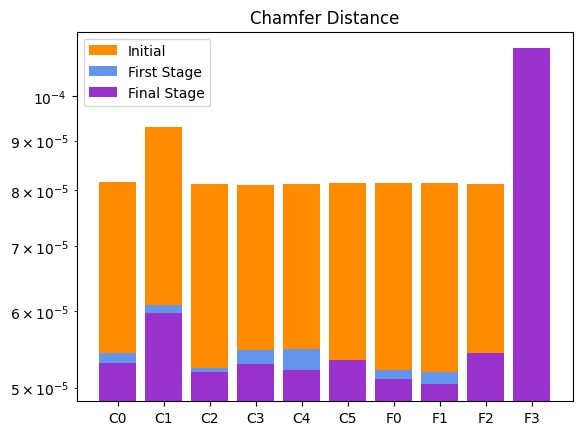

In [4]:
plot_stacked_bar_chart(all_avg_vals, "Chamfer Distance", "chamfer", yscale=True)

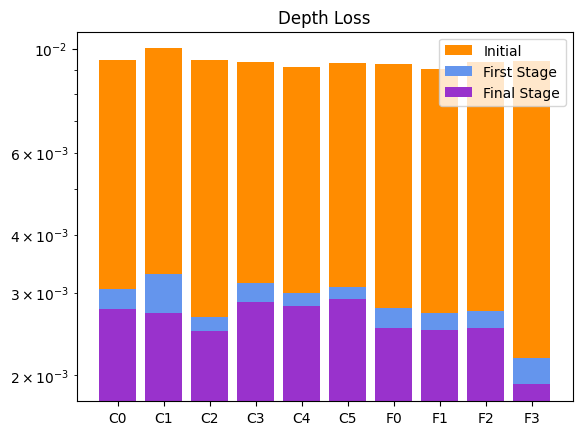

In [5]:
plot_stacked_bar_chart(all_avg_vals, "Depth Loss", "depth_loss")

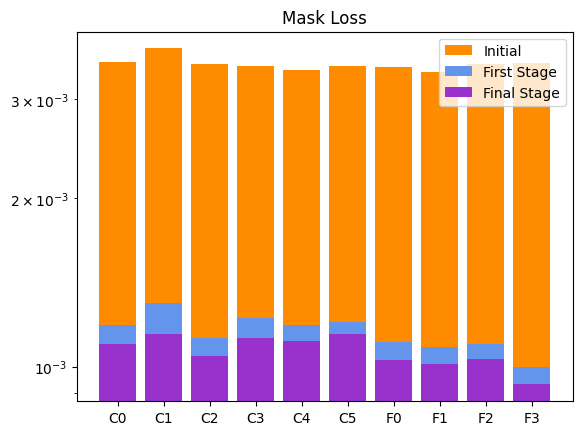

In [6]:
plot_stacked_bar_chart(all_avg_vals, "Mask Loss", "mask_loss")

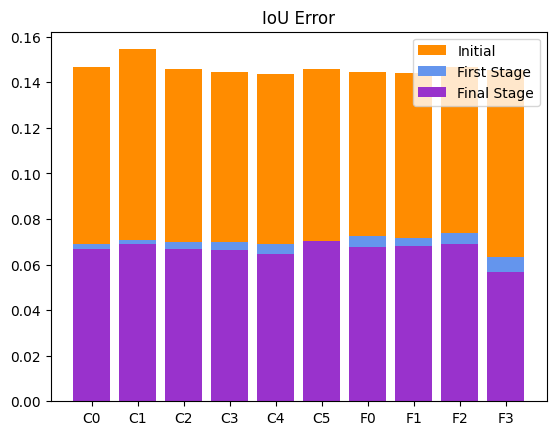

In [7]:
plot_stacked_bar_chart(all_avg_vals, "IoU Error", "iou", yscale=False)

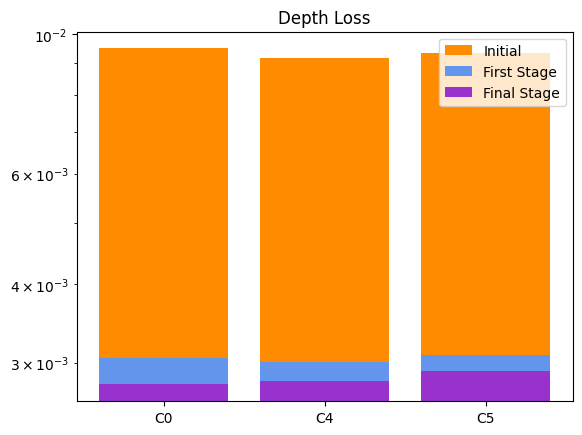

In [8]:
plot_stacked_bar_chart(all_avg_vals, "Depth Loss", "depth_loss", key_filters=["C4", "C0", "C5"])

In [17]:
from copy import deepcopy

# make a table with all metrics and all configurations
def print_table(data, key_filters=None):
    # Deep clone data dict
    data = deepcopy(data)
    labels = sorted(list(data.keys()))
    if key_filters is not None:
        labels = [l for l in labels if l in key_filters]
    matrix = []
    print("Configuration\tChamfer (Initial)\tChamfer (First Stage)\tChamfer (Final Stage)\tDepth Loss (Initial)\tDepth Loss (First Stage)\tDepth Loss (Final Stage)\tIoU (Initial)\tIoU (First Stage)\tIoU (Final Stage)\tMask Loss (Initial)\tMask Loss (First Stage)\tMask Loss (Final Stage)")
    for label in labels:
        final = data[label]["final"]
        first_stage = data[label]["first_stage"]
        initial = data[label]["initial"]
        # Scale all chamfer values by 10**4
        initial["chamfer"] *= 10**4
        first_stage["chamfer"] *= 10**4
        final["chamfer"] *= 10**4
        # Scale all depth loss values by 10**2
        initial["depth_loss"] *= 10**2
        first_stage["depth_loss"] *= 10**2
        final["depth_loss"] *= 10**2
        # Scale all mask loss values by 10**2
        initial["mask_loss"] *= 10**2
        first_stage["mask_loss"] *= 10**2
        final["mask_loss"] *= 10**2
        print(f"{label}\t{initial['chamfer']:.4f}\t{first_stage['chamfer']:.4f}\t{final['chamfer']:.4f}\t{initial['depth_loss']:.4f}\t{first_stage['depth_loss']:.4f}\t{final['depth_loss']:.4f}\t{initial['iou']:.4f}\t{first_stage['iou']:.4f}\t{final['iou']:.4f}\t{initial['mask_loss']:.4f}\t{first_stage['mask_loss']:.4f}\t{final['mask_loss']:.4f}")

        matrix += [[initial["chamfer"], first_stage["chamfer"], final["chamfer"], initial["depth_loss"], first_stage["depth_loss"], final["depth_loss"], initial["iou"], first_stage["iou"], final["iou"], initial["mask_loss"], first_stage["mask_loss"], final["mask_loss"]]]
    return matrix
mat = print_table(all_avg_vals)

Configuration	Chamfer (Initial)	Chamfer (First Stage)	Chamfer (Final Stage)	Depth Loss (Initial)	Depth Loss (First Stage)	Depth Loss (Final Stage)	IoU (Initial)	IoU (First Stage)	IoU (Final Stage)	Mask Loss (Initial)	Mask Loss (First Stage)	Mask Loss (Final Stage)
C0	0.8158	0.5437	0.5310	0.9491	0.3052	0.2772	0.8532	0.9308	0.9333	0.3500	0.1190	0.1098
C1	0.9302	0.6087	0.5976	1.0025	0.3288	0.2722	0.8455	0.9292	0.9310	0.3697	0.1302	0.1144
C2	0.8111	0.5239	0.5197	0.9454	0.2670	0.2491	0.8541	0.9302	0.9330	0.3469	0.1127	0.1047
C3	0.8104	0.5469	0.5288	0.9371	0.3148	0.2864	0.8557	0.9302	0.9335	0.3443	0.1223	0.1126
C4	0.8126	0.5480	0.5225	0.9166	0.3004	0.2809	0.8562	0.9311	0.9352	0.3380	0.1188	0.1111
C5	0.8144	0.5336	0.5342	0.9325	0.3088	0.2907	0.8544	0.9297	0.9298	0.3434	0.1202	0.1146
F0	0.8143	0.5216	0.5114	0.9304	0.2783	0.2527	0.8557	0.9273	0.9323	0.3432	0.1110	0.1027
F1	0.8131	0.5188	0.5042	0.9074	0.2718	0.2496	0.8561	0.9285	0.9320	0.3360	0.1085	0.1012
F2	0.8118	0.5156	0.5438	0.9392	0.2742	0

In [21]:
import numpy as np

mat = np.array(mat)
# Min-max normalize every column
mat = (mat - mat.min(axis=0)) / (mat.max(axis=0) - mat.min(axis=0))

In [23]:
# Compute row-wise average
row_avg = np.mean(mat, axis=1)

In [28]:
print("\n".join([str(k) for k in row_avg]))

0.47619900763273854
0.6942110237428148
0.35391416238892326
0.5002549220328757
0.4603782760622314
0.4505815307559778
0.3147966027593125
0.26383262981373523
0.29131869316166487
0.4065136352716998
